#**Introduction**
In this notebook, I will implement a machine-learning framework to accelerate Invar discovery.Invar alloy is a kind of alloys with low thermal expansion coefficient (TEC). With the framework I will try to find unlabled alloys with low TEC. 

In [11]:
import cv2
import os
import time
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

sns.set(color_codes=True)

#**Required packages**

In [12]:
!pip install bayesian-optimization
!pip install lightgbm

#**Wasserstein Autoencoder (initial data analysis)**
Wasserstein autoencoder is used for learning the latent space representation.

the block below shows two utility functions that converting numpy array to 
tensors.

In [36]:
class FeatureDataset(Dataset): #from numpy to tensor (pytroch-readable)
    '''
    Args: x is a 2D numpy array [x_size, x_features]
    '''
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx]), torch.FloatTensor(self.y[idx])


**Model architecture**

In [37]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

class WAE(nn.Module):
    def __init__(self, input_size):
        super(WAE, self).__init__()
        self.input_size = input_size

        # encoder
        self.encoder = nn.Sequential(
                        nn.Linear(self.input_size, 80),
                        nn.LayerNorm(80),
                        nn.ReLU(),
                        nn.Linear(80, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 48),
                        nn.LayerNorm(48),
                        nn.ReLU(),
                        nn.Linear(48, 2),
                        )

        # decoder
        self.decoder = nn.Sequential(
                        nn.Linear(2, 48),
                        nn.LayerNorm(48),
                        nn.ReLU(),
                        nn.Linear(48, 64),
                        nn.LayerNorm(64),
                        nn.ReLU(),
                        nn.Linear(64, 80),
                        nn.LayerNorm(80),
                        nn.ReLU(),
                        nn.Linear(80, self.input_size),
                        nn.Softmax(dim=1) #(softmad along dimension 1)
                        )
        self.apply(weights_init)
    
    def forward(self, x):
        z = self._encode(x)
        x_recon = self._decode(z)

        return x_recon, z
    
    def _encode(self, x):
        return self.encoder(x)

    def _decode(self, z):
        return self.decoder(z)

**Utility functions for WAE**


*   same_seeds: fixing the randomness
*   get_latents: get the latent spaces from the WAE
*   imq_kernels: inverse multiquadric (IMQ) kernel - computing the maximum mean discrepancy, which is part of the loss function for WAE.



In [38]:
def same_seeds(seed): #fix np & torch seed to the same.
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

def get_latents(model, dataset): #from dataset to altten
    model.to(device).eval() # training model or evaluation mode, eval means setting the model to its evaluation mode (gradient fixed)
    latents = []
    with torch.no_grad(): # fix the gradient, assure that the model parameters are fixed
        dataloader = DataLoader(dataset, batch_size=256, shuffle=False)
        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            recon_x, z = model(x)
            latents.append(z.detach().cpu().numpy())
    return np.concatenate(latents,axis=0)

def imq_kernel(X: torch.Tensor, Y: torch.Tensor, h_dim: int): # common kerntl to choose
    batch_size = X.size(0)

    norms_x = X.pow(2).sum(1, keepdim=True)  # batch_size x 1
    prods_x = torch.mm(X, X.t()).to(device)  # batch_size x batch_size
    dists_x = norms_x + norms_x.t() - 2 * prods_x # mm matrix multiplicaiton

    norms_y = Y.pow(2).sum(1, keepdim=True).to(device)  # batch_size x 1
    prods_y = torch.mm(Y, Y.t()).to(device)  # batch_size x batch_size
    dists_y = norms_y + norms_y.t() - 2 * prods_y

    dot_prd = torch.mm(X, Y.t())
    dists_c = norms_x + norms_y.t() - 2 * dot_prd

    stats = 0
    for scale in [.1, .2, .5, 1., 2., 5., 10.]: # need more study on this
        C = 2 * h_dim * 1.0 * scale
        res1 = C / (C + dists_x)
        res1 += C / (C + dists_y)

        if torch.cuda.is_available():
            res1 = (1 - torch.eye(batch_size).to(device)) * res1
        else:
            res1 = (1 - torch.eye(batch_size)) * res1

        res1 = res1.sum() / (batch_size - 1)
        res2 = C / (C + dists_c)
        res2 = res2.sum() * 2. / (batch_size)
        stats += res1 - res2

    return stats


**Data loading**  

params - here you can play around with all different combinations of paramters to reduce the total loss. You can visualize your training history just to see how good your chosen set of hyperparameters performs

In [39]:
same_seeds(1) #seed equals to 1

params = {
    'num_epoch' : 200,
    'batch_size' : 20,
    'lr' : 5e-4,
    'weight_decay' : 0.0,
    'sigma' : 8.0,
    'MMD_lambda' : 1e-4,
    'model_name' : 'WAE',
} # for WAE training
all = pd.read_excel('Data_base_Invar.xlsx', header=0).iloc[:,1:23].to_numpy()
raw_x = all[:,0:6]
raw_y = all[:,20].reshape(-1,1)
dataset = FeatureDataset(raw_x[:], raw_y[:]) #numpy to tensor
dataloader = DataLoader(dataset, batch_size=params['batch_size'], shuffle=True) # tensor to dataloader
print(raw_x[0:5],raw_y[0:5])#check the input and target

[[1.   0.   0.   0.   0.   0.  ]
 [0.95 0.05 0.   0.   0.   0.  ]
 [0.9  0.1  0.   0.   0.   0.  ]
 [0.85 0.15 0.   0.   0.   0.  ]
 [0.8  0.2  0.   0.   0.   0.  ]] [[11.92]
 [11.17]
 [10.82]
 [ 9.91]
 [11.09]]


C:\Challenge\WAE
[001/200] loss: 0.387408 Recon_loss: 0.386873, MMD_loss:5.346743
[002/200] loss: 0.329921 Recon_loss: 0.329467, MMD_loss:4.543360
[003/200] loss: 0.305827 Recon_loss: 0.305424, MMD_loss:4.026863
[004/200] loss: 0.298453 Recon_loss: 0.298004, MMD_loss:4.489691
[005/200] loss: 0.293574 Recon_loss: 0.293141, MMD_loss:4.327320
[006/200] loss: 0.290646 Recon_loss: 0.290203, MMD_loss:4.430720
[007/200] loss: 0.288276 Recon_loss: 0.287816, MMD_loss:4.600193
[008/200] loss: 0.286795 Recon_loss: 0.286342, MMD_loss:4.527824
[009/200] loss: 0.285829 Recon_loss: 0.285367, MMD_loss:4.618772
[010/200] loss: 0.285057 Recon_loss: 0.284605, MMD_loss:4.527849
[011/200] loss: 0.284265 Recon_loss: 0.283813, MMD_loss:4.522617
[012/200] loss: 0.284208 Recon_loss: 0.283746, MMD_loss:4.623925
[013/200] loss: 0.283704 Recon_loss: 0.283252, MMD_loss:4.515644
[014/200] loss: 0.283420 Recon_loss: 0.282955, MMD_loss:4.652357
[015/200] loss: 0.283332 Recon_loss: 0.282871, MMD_loss:4.615030
[016/200

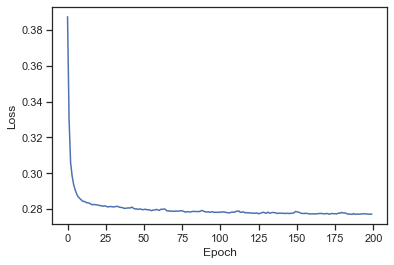

In [40]:
model = WAE(raw_x.shape[1]).to(device) # initialize the model 
optimizer = Adam(model.parameters(), lr = params['lr'], weight_decay = params['weight_decay']) # optimizer
def train_WAE(model, optimizer, dataloader, params):
    model_name = params['model_name']
    num_epoch = params['num_epoch']
    sigma = params['sigma'] # assuming the latent space follows Gaussian
    MMD_lambda = params['MMD_lambda'] #WAE distance (maximum mean discrepancy)

    folder_dir = os.path.join(os.getcwd(), model_name) # a folder to save models
    print(folder_dir)
    if not os.path.isdir(folder_dir):
        os.mkdir(folder_dir)
    loss_=[]   
    for epoch in range(num_epoch):
        #start_time = time.time()
        total_loss = [] #save for plot, recon loss+MMD
        total_recon = [] # binary cross entropy
        total_MMD = [] #maximum mean discrepancy
        
        for i, data in enumerate(dataloader):
            x = data[0].to(device)
            y = data[1].to(device)
            model.train() # model goes to train mode
            recon_x, z_tilde = model(x) # latent space is Z_tilde
            z = sigma*torch.randn(z_tilde.size()).to(device) # z is sampled from a Gaussian that has the same dimension (but no relation to z_tilde).

            recon_loss = F.binary_cross_entropy(recon_x, x, reduction='mean') #lowest reconstruction loss 
            #recon_loss = F.mse_loss(recon_x, x, reduction='mean') 
            #recon_loss = F.l1_loss(recon_x, x, reduction='mean')
            
            MMD_loss = imq_kernel(z_tilde, z, h_dim=2).to(device) #W-distance between z_tilde and z
            MMD_loss = MMD_loss / x.size(0) #averaging, because recon loss is mean.
            loss = recon_loss + MMD_loss * MMD_lambda #MM_lambda: learning-rate alike, hyperparamer

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss.append(loss.item())# from tensor to values
            total_recon.append(recon_loss.item())
            total_MMD.append(MMD_loss.item())

        avg_loss = sum(total_loss)/len(total_loss)
        avg_recon = sum(total_recon)/len(total_recon)
        avg_MMD = sum(total_MMD)/len(total_MMD)
        loss_.append(avg_loss)

        #scheduler.step(avg_loss)

        print('[{:03}/{:03}] loss: {:.6f} Recon_loss: {:.6f}, MMD_loss:{:.6f}'.format(\
                                        epoch+1, num_epoch, \
                                        avg_loss, \
                                        avg_recon, avg_MMD))
        # save the model every 5 epoches
        if (epoch+1) % 5 == 0:
            save_model_dir = str(model_name + "_{}.pth".format(epoch+1))
            torch.save(model.state_dict(), os.path.join(folder_dir, save_model_dir))
    return loss_

loss_=train_WAE(model, optimizer, dataloader, params)
plt.figure()
sns.set_style('ticks')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(len(loss_)),loss_)

**Double check on the reconstructed compositions**




*   one way to find out whether WAE (or any other VAE) has learned the 
repsentation is to compare the reconstructed and original compositions.if you are not happy with the reconstruction. go back to the previous step and change the params. 



In [18]:
#double check on the recontructed compositions
#t = time.localtime()
model_name = params['model_name']
folder_dir = os.path.join(os.getcwd(), model_name)
model_dir = os.path.join(folder_dir,'{}_{}.pth'.format(params['model_name'],params['num_epoch']))#load your model
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
model.eval()
with torch.no_grad():
    test = torch.FloatTensor(raw_x).to(device)
    recon_x, z = model(test)
    recon_x = model.decoder(z)
    recon_x = recon_x.cpu().detach().numpy()

column_name = ['Fe','Ni','Co','Cr','V','Cu']
#recon_x = (recon_x * (max-min)) + min
pd.DataFrame(recon_x.round(3), columns=column_name).iloc[0:5]#print the reconstruction

,Fe,Ni,Co,Cr,V,Cu
0,0.997,0.002,0.001,0.0,0.000,0.0
1,0.950,0.050,0.000,0.0,0.000,0.0
2,0.892,0.108,0.000,0.0,0.000,0.0
3,0.843,0.156,0.000,0.0,0.000,0.0
4,0.793,0.206,0.000,0.0,0.002,0.0


In [19]:
raw_x[0:5,:6].round(3)#print the real composition

array([[1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.95, 0.05, 0.  , 0.  , 0.  , 0.  ],
       [0.9 , 0.1 , 0.  , 0.  , 0.  , 0.  ],
       [0.85, 0.15, 0.  , 0.  , 0.  , 0.  ],
       [0.8 , 0.2 , 0.  , 0.  , 0.  , 0.  ]])

**Visualize the WAE latent space**

Here we assign different colors to alloy with and without Copper,
as we expected them to differ significantly in the latent space.



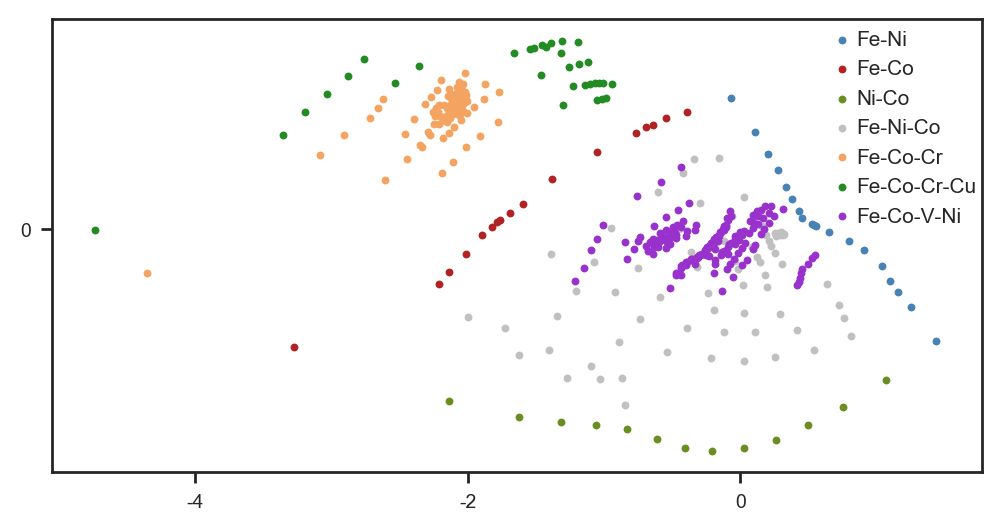

In [22]:
sns.set_style('ticks')
model = WAE(raw_x.shape[1]).to(device)
model.load_state_dict(torch.load(model_dir))
dataset = FeatureDataset(raw_x[:], raw_y[:])
latents = get_latents(model, dataset)

# figure settings
fig, axs = plt.subplots(figsize = (6, 3),dpi=200)

axs.set_yticks(np.arange(-6, 8, step=2))
axs.set_xticks(np.arange(-10, 5, step=2))

axs.set_yticklabels(np.arange(-6, 8, step=2), fontsize=7)
axs.set_xticklabels(np.arange(-10, 5, step=2), fontsize=7)

for axis in ['top','bottom','left','right']:
  axs.spines[axis].set_linewidth(1.)

axs.tick_params(axis='both', which='major', top=False, labeltop=False, direction='out', width=1., length=4)
axs.tick_params(axis='both', which='major', right=False, labelright=False, direction='out', width=1., length=4)

#choose differnt label from the dataset and plot the distribution
scatter1 = axs.scatter(latents[0:19,0],latents[0:19,1], c='steelblue', alpha=1, s=8, linewidths=0, label='Fe-Ni')
scatter2 = axs.scatter(latents[19:36,0],latents[19:36,1], c='firebrick', alpha=1, s=8, linewidths=0, label='Fe-Co')
scatter3 = axs.scatter(latents[36:49,0],latents[36:49,1], c='olivedrab', alpha=1, s=8, linewidths=0, label='Ni-Co')
scatter4 = axs.scatter(latents[49:118,0],latents[49:118,1], c='silver', alpha=1, s=8, linewidths=0, label='Fe-Ni-Co')
scatter5 = axs.scatter(latents[118:203,0],latents[118:203,1], c='sandybrown', alpha=1, s=8, linewidths=0, label='Fe-Co-Cr')
scatter6 = axs.scatter(latents[203:235,0],latents[203:235,1], c='forestgreen', alpha=1, s=8, linewidths=0, label='Fe-Co-Cr-Cu')
scatter7 = axs.scatter(latents[235:397,0],latents[235:397,1], c='darkorchid', alpha=1, s=8, linewidths=0, label='Fe-Co-V-Ni')

handles,labels = axs.get_legend_handles_labels()#Return handles and labels for legend
handles = handles[::1]
labels = labels[::1]

legend_properties = {'size':7.5}
axs.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.015,1.017), handletextpad=-0.3, frameon=False, prop=legend_properties)


# **Neural network and GBDT model and Bayesian Optimization (BO)**

**Ultility functions**
*   MAPELoss - Mean Absolute Percentile Error (MAPE)
we use MAPE loss because the loss is more sensitive to small TEC which is our target
*   normalizing_data - Normalizing the data



In [23]:
import torch.nn as nn
import torch
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import random

class MAPELoss(nn.Module):
     def __init__(self):
        super(MAPELoss, self).__init__() 
        
     def forward (self, output, target):
         loss = torch.mean(torch.abs((target - output) / target))
         # loss = (-1)*loss
         return loss
     
def minmaxscaler(data):
    min = np.amin(data)
    max = np.amax(data)    
    return (data - min)/(max-min)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class FeatureDataset(Dataset):
    '''
    Args: x is a 2D numpy array [x_size, x_features]
    '''
    def __init__(self, x):
        self.x = x
    
    def __len__(self):
        return self.x.shape[0]
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.x[idx])

    def getBatch(self, idxs = []):
        if idxs == None:
            return idxs
        else:
            x_features = []
            for i in idxs:
                x_features.append(self.__getitem__(i))
            return torch.FloatTensor(x_features)
        
def normalizing_data(data, seed=42): #norminliz the data 
  df_all = data.drop(columns=['alloy'])
  #create a min max processing object
  composition = df_all [['Fe','Ni','Co','Cr','V','Cu']]
  min_max_scaler = preprocessing.MinMaxScaler()
  normalized_atomic_properties = min_max_scaler.fit_transform(df_all[['VEC','AR1','AR2','PE','Density',
                                              'TC','MP','FI','SI','TI','M','TC','MS','MagS']])
  x = pd.concat([composition,pd.DataFrame(normalized_atomic_properties)],axis=1)
  y = df_all[['TEC']][:714]
  bins     = [18,35,48,109,202,234,525,687]
  y_binned = np.digitize(y.index, bins, right=True) #stratified 7-fold: each folder contains a specific type of alloys (7 types in total, each takes 85% and 15% as training and testing)
  
  x_all = torch.FloatTensor(x.values) #numpy to tensor
  y_all = torch.FloatTensor(y.values) #numpy to tensor

  if torch.cuda.is_available():
      x_all = x_all.cuda()
      y_all = y_all.cuda() 
  
  train_features, test_features, train_labels, test_labels = train_test_split(x_all, y_all, test_size=0.15, random_state=seed, stratify=y_binned)
  return x_all, y_all, train_features, test_features, train_labels, test_labels

**Data loading**

In [24]:
import datetime
import torch.utils.data as Data
import pandas as pd
import torch
import torch.nn.functional as F    
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from sklearn import preprocessing

#t = time.localtime()   
table = pd.DataFrame(columns=['target','batch_size','lr','module__n_hidden','module__w'])

plt.close('all')
starttime = datetime.datetime.now()
data = pd.read_excel('Data_base_Invar.xlsx')


x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data, seed=42)

**Neural network architecture**

In [25]:
class Net(nn.Module):  
    def __init__(self, n_feature=20, n_hidden=218, n_output=1, w = 6):
        super(Net, self).__init__()    
        # self.BN=torch.nn.BatchNorm1d(n_hidden)#this does not help 
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden) 
        nn.init.kaiming_normal_(self.hidden1.weight)#better initialize 
        
        self.hiddens = nn.ModuleList ([nn.Linear(n_hidden, n_hidden) for i in range(w)])                            
        for m in self.hiddens:
            nn.init.kaiming_normal_(m.weight)#better initialize   
        
        self.predict = torch.nn.Linear(n_hidden, n_output)  
        nn.init.kaiming_normal_(self.predict.weight)

    def forward(self, x):  
        x = self.hidden1(x)
        # x = self.BN(x)
        # x = self.Dropout (x)#this also does not help for small dataset
        x = F.relu(x)   
        
        for m in self.hiddens:
            x = m(x)
            # x = self.BN(x)
            x = F.relu(x) 
                      
        x = self.predict(x)
        # x = self.BN_3(x)
        # x = self.Dropout (x)
          # 输出值
        return x

def train(net, num_epochs, batch_size, train_features, test_features, train_labels, test_labels,
          train_loader,
          optimizer):
    print ("\n=== train begin ===")
    #print(net) #if you want to know the structure
    train_ls, test_ls = [], []
    loss = MAPELoss() # MAPE means Mean Absolute percentile error 
    for epoch in range(num_epochs):
        for x, y in train_loader:
            ls = loss(net(x).view(-1, 1), y.view(-1, 1))
            optimizer.zero_grad()
            ls.backward()
            optimizer.step()
        if epoch % 100 == 0:
            train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
            test_ls.append(loss(net(test_features).view(-1, 1), test_labels.view(-1, 1)).item())
            print ("epoch %d: train loss %f, test loss %f" % (epoch, train_ls[-1], test_ls[-1]))
        
    print ("=== train end ===")

  
def test(model, test_loader): 
    model.eval()
    test_loss = 0
    n = 0
    loss = MAPELoss() 
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += loss(output.view(-1, 1), target.view(-1, 1)).item()  # sum up batch loss
            n += 1

    test_loss /= n
    
    print('Test set: Average loss: {:.4f}'.format(
        test_loss))
    
    return test_loss 

def plotCurve(x_vals, y_vals, 
                        x_label, y_label, 
                        x2_vals=None, y2_vals=None, 
                        legend=None,
                        figsize=(3.5, 2.5)):
            # set figsize
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.plot(x_vals, y_vals)
            if x2_vals and y2_vals:
                plt.plot(x2_vals, y2_vals, linestyle=':')      
            if legend:
                plt.legend(legend)

        

**Bayesian hyperparameter optimization** we use BO to find the best parameters for NN



In [27]:
import os
import time
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
import datetime
import pandas as pd
def train_model(batch_size,lr, module__n_hidden,module__w):
    module__n_hidden = int(module__n_hidden) # number of neurons per layer
    module__w = int(module__w) # number of hidden layers
    batch_size = int(batch_size)
    train_dataset = Data.TensorDataset(train_features, train_labels)
    test_dataset = Data.TensorDataset(test_features, test_labels)
    train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
    test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True) 
    net = Net(n_feature=20, n_hidden=module__n_hidden, n_output=1, w = module__w)
    if torch.cuda.is_available():
      net = net.cuda()
    n_epochs = 1000 
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
    train(net, n_epochs, batch_size,train_features, test_features, 
          train_labels, test_labels,train_loader, optimizer)
    train_loss= test(net,train_loader)
    test_loss = test(net, test_loader)

    
    r = -np.abs(train_loss-test_loss)
    
    return -test_loss

bounds = {'lr': (0.0005,0.001), 'batch_size': (32,64), 'module__n_hidden': (16,526),
          'module__w': (2,10)} #this is the bounds where you are trying to find the best parameter combination
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)

optimizer.maximize(init_points=1, n_iter=1)#init_points is where you start and do n_iterations (n_iter) BO
print(optimizer.max)
table = pd.DataFrame(columns=['target','batch_size','lr','module__n_hidden','module__w']) #save the results into a dataframe
for res in optimizer.res:
    table=table.append(pd.DataFrame({'target':[res['target']],'batch_size':[res['params']['batch_size']],
                                     'lr':[res['params']['lr']], 'module__n_hidden':[res['params']['module__n_hidden']],
                                     'module__w':[res['params']['module__w']]}),ignore_index=True)

table=table.sort_values(by = ['target'],ascending=False)#sort the list start from the best results
model_name = 'Invar_BO_NN'
file_name = '{}.xlsx'.format(model_name)
#endtime = datetime.datetime.now()
#Rtime = endtime - starttime #if it takes long time you can record it.
#print(Rtime)
table.to_excel(file_name)#save the results to the table
print(table)

|   iter    |  target   | batch_... |    lr     | module... | module__w |
-------------------------------------------------------------------------

=== train begin ===
epoch 0: train loss 0.987380, test loss 0.993638
epoch 100: train loss 0.330359, test loss 0.268757
epoch 200: train loss 0.235657, test loss 0.251957
epoch 300: train loss 0.230207, test loss 0.209035
epoch 400: train loss 0.180139, test loss 0.295076
epoch 500: train loss 0.167851, test loss 0.206400
epoch 600: train loss 0.154897, test loss 0.194336
epoch 700: train loss 0.152563, test loss 0.241004
epoch 800: train loss 0.182179, test loss 0.238700
epoch 900: train loss 0.139260, test loss 0.243846
=== train end ===
Test set: Average loss: 0.1321
Test set: Average loss: 0.2259
|  1        | -0.2259   |  45.34    |  0.000860 |  16.06    |  4.419    |

=== train begin ===
epoch 0: train loss 1.019206, test loss 1.092481
epoch 100: train loss 0.226122, test loss 0.260466
epoch 200: train loss 0.237534, test loss 0.2377

**We also use BO to optimize the parameters of Gradient Boosting Decision Tree Ensemble (GBDT)**

In [28]:
import os
import time
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
import datetime
import pandas as pd

#t = time.localtime()
model_name = 'Invar_BO_GBDT'
file_name = '{}.xlsx'.format(model_name)
data = pd.read_excel('Data_base_Invar.xlsx')
x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data,seed=42)
train_features, test_features = train_features.cpu().data.numpy(),test_features.cpu().data.numpy()
train_labels, test_labels = train_labels.cpu().data.numpy(), test_labels.cpu().data.numpy()
train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1) 
def train_model(num_leaves,
                min_child_samples,
            learning_rate,
            n_estimators, 
            max_bin,
            colsample_bytree, 
            subsample, 
            max_depth, 
            reg_alpha,
            reg_lambda,
            min_split_gain,
            min_child_weight
            ):
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples':int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_alpha':  max(reg_alpha, 0),
        'reg_lambda': max(reg_lambda, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'verbose': -1
                  } #the parameters you want to optimize
    model = LGBMRegressor(metric='mape',**params)
    model.fit(train_features, train_labels)
    y_pred = model.predict(test_features)
    error = -np.mean(np.abs((test_labels - y_pred) / test_labels))       # print(error)     
    return error
bounds = {'num_leaves': (5, 60),#50
          'min_child_samples':(1, 50),
          'learning_rate': (0.001, 1),
          'n_estimators': (5, 200),#100
            'max_bin': (5, 100),#10
          'colsample_bytree': (0.5, 1),
          'subsample': (0.1, 2),
          'max_depth': (1, 60),#10
          'reg_alpha': (0.01, 1), #5
          'reg_lambda': (0.01, 1),#5
          'min_split_gain': (0.001, 0.1),
          'min_child_weight': (0.0001, 30)}
optimizer = BayesianOptimization(
    f=train_model,
    pbounds=bounds,
    random_state=1,
)
optimizer.maximize(init_points = 50, n_iter=50) #here you set how many iterations you want.
table = pd.DataFrame(columns=['target', 'colsample_bytree', 'learning_rate', 'max_bin',
                      'max_depth','min_child_samples','min_child_weight','min_split_gain',
                      'n_estimators','num_leaves','reg_alpha','reg_lambda','subsample'])
for res in optimizer.res:
    table=table.append(pd.DataFrame({'target':[res['target']],'colsample_bytree':[res['params']['colsample_bytree']],
                                     'colsample_bytree':[res['params']['colsample_bytree']],
                                     'learning_rate':[res['params']['learning_rate']],
                                     'max_bin':[res['params']['max_bin']],
                                     'max_depth':[res['params']['max_depth']],
                                     'min_child_samples':[res['params']['min_child_samples']],
                                     'min_child_weight':[res['params']['min_child_weight']],
                                     'min_split_gain':[res['params']['min_split_gain']],
                                     'n_estimators':[res['params']['n_estimators']],
                                     'num_leaves':[res['params']['num_leaves']],
                                     'reg_alpha':[res['params']['reg_alpha']],
                                     'reg_lambda':[res['params']['reg_lambda']],
                                     'subsample':[res['params']['subsample']]}),
                                     ignore_index=True)
table=table.sort_values(by = ['target'],ascending=False)#sort the list start from the best results
table.to_excel(file_name)#save the results to the table
#endtime = datetime.datetime.now()
#print ('running time {}'.format(endtime - starttime))

|   iter    |  target   | colsam... | learni... |  max_bin  | max_depth | min_ch... | min_ch... | min_sp... | n_esti... | num_le... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -2.023    |  0.7085   |  0.7206   |  5.011    |  18.84    |  8.191    |  2.77     |  0.01944  |  72.38    |  26.82    |  0.5434   |  0.425    |  1.402    |
|  2        | -1.07     |  0.6022   |  0.8782   |  7.602    |  40.56    |  21.45    |  16.76    |  0.0149   |  43.63    |  49.04    |  0.9686   |  0.3203   |  1.415    |
|  3        | -0.3522   |  0.9382   |  0.8947   |  13.08    |  3.304    |  9.322    |  26.34    |  0.01074  |  87.12    |  57.68    |  0.5378   |  0.695    |  0.6995   |
|  4        | -1.191    |  0.8433   |  0.8348   |  6.737    |  45.26    |  49.45    |  22.44    |  0.02876  |  158.9    |  10.68    |  0.4534   |  0.9

# **Assess the performance/accuracy of NN**


=== train begin ===
Net(
  (hidden1): Linear(in_features=20, out_features=218, bias=True)
  (hiddens): ModuleList(
    (0): Linear(in_features=218, out_features=218, bias=True)
    (1): Linear(in_features=218, out_features=218, bias=True)
    (2): Linear(in_features=218, out_features=218, bias=True)
    (3): Linear(in_features=218, out_features=218, bias=True)
    (4): Linear(in_features=218, out_features=218, bias=True)
    (5): Linear(in_features=218, out_features=218, bias=True)
  )
  (predict): Linear(in_features=218, out_features=1, bias=True)
)
epoch 0: train loss 1.043636, test loss 1.387072
epoch 100: train loss 0.183117, test loss 0.215111
epoch 200: train loss 0.112955, test loss 0.178827
epoch 300: train loss 0.114419, test loss 0.187405
epoch 400: train loss 0.271353, test loss 0.365154
epoch 500: train loss 0.213110, test loss 0.266117
epoch 600: train loss 0.092568, test loss 0.181128
epoch 700: train loss 0.123951, test loss 0.194383
epoch 800: train loss 0.133908, test

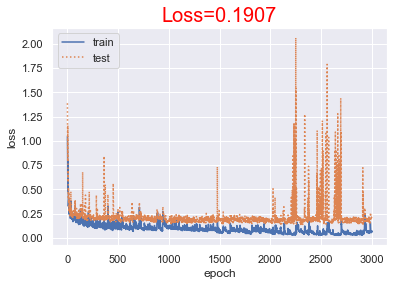

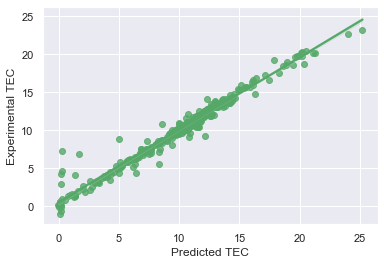

In [30]:
import seaborn as sns
sns.set(color_codes=True)
target = pd.read_excel('Invar_BO_NN.xlsx')#get the best BO parameter for NN
lr = target.at[1,'lr'] 
module__n_hidden = target.at[1,'module__n_hidden']
module__w = target.at[1,'module__w']
batch_size = target.at[1,'batch_size']

module__n_hidden = int(module__n_hidden)
module__w = int(module__w)
batch_size = int(batch_size)

#get the data
x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data)
train_dataset = Data.TensorDataset(train_features, train_labels)
test_dataset = Data.TensorDataset(test_features, test_labels)
train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True) 

#train the NN with the data and paramters

print ("\n=== train begin ===")
net = Net()
print(net)
if torch.cuda.is_available():
    net = net.cuda()    
train_ls, test_ls = [], []
loss = MAPELoss() 
n_epochs = 3000
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
for epoch in range(n_epochs):
    for x, y in train_loader:
        ls = loss(net(x).view(-1, 1), y.view(-1, 1))
        optimizer.zero_grad()
        ls.backward()
        optimizer.step()
    train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
    test_ls.append(loss(net(test_features).view(-1, 1), test_labels.view(-1, 1)).item())
    if epoch % 100 == 0:
        print ("epoch %d: train loss %f, test loss %f" % (epoch, train_ls[-1], test_ls[-1]))
print ("plot curves")
plotCurve(range(1, n_epochs + 1), train_ls,"epoch", "loss",range(1, n_epochs + 1), test_ls,["train", "test"])
plt.title('Loss=%.4f' % test_ls[-1], fontdict={'size': 20, 'color':  'red'})
folder_dir = 'Figures'
if not os.path.isdir(folder_dir):
  os.mkdir(folder_dir)
fig_name = 'Figures/NN_trainning history'
plt.savefig(fig_name, format='png', dpi=300)            
            
#plotting experimental results as a change of predicted TEC 
net.eval()
predict=net(x_all)
predict=predict.cpu()
predict=predict.data.numpy()  
plt.figure()
sns.regplot(x=predict, y=y_all.cpu().data.numpy(), color='g') 
plt.xlabel('Predicted TEC')
plt.ylabel('Experimental TEC')
fig_name_2 = 'Figures/NN_expriements and predict comparasion.png'
plt.savefig(fig_name_2, format='png', dpi=300)
  
#save the models
folder_dir = 'Model'
if not os.path.isdir(folder_dir):
  os.mkdir(folder_dir)
net_name = 'Model/Invar_NN.pt'
torch.save(net.state_dict(), net_name)

# **Assess the performance/accuracy of GBDT**

[10]	training's mape: 0.200956	valid_0's mape: 0.18411
[20]	training's mape: 0.168111	valid_0's mape: 0.181665
[30]	training's mape: 0.145025	valid_0's mape: 0.159067
[40]	training's mape: 0.130601	valid_0's mape: 0.150776
[50]	training's mape: 0.116475	valid_0's mape: 0.15441
[60]	training's mape: 0.108903	valid_0's mape: 0.153502
[70]	training's mape: 0.101132	valid_0's mape: 0.14731
[80]	training's mape: 0.098405	valid_0's mape: 0.154463
[90]	training's mape: 0.0931256	valid_0's mape: 0.153016
[100]	training's mape: 0.0862284	valid_0's mape: 0.153471
[110]	training's mape: 0.0841274	valid_0's mape: 0.15458
[120]	training's mape: 0.0834368	valid_0's mape: 0.156402
[130]	training's mape: 0.0834368	valid_0's mape: 0.156402
[140]	training's mape: 0.0834368	valid_0's mape: 0.156402


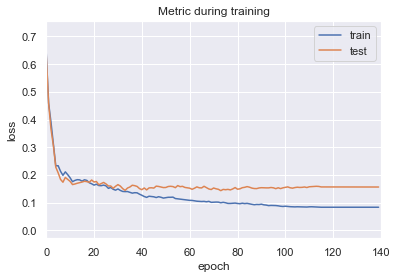

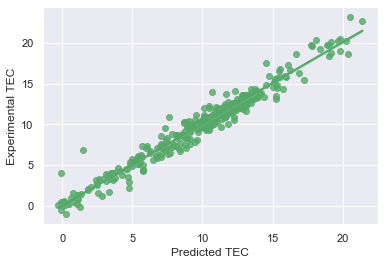

In [31]:
import lightgbm as lgb
#load the parameters of BO
target = pd.read_excel('Invar_BO_GBDT.xlsx')
colsample_bytree = target.at[1,'colsample_bytree']
learning_rate = target.at[1,'learning_rate']
max_bin = target.at[1,'max_bin']
max_depth = target.at[1,'max_depth']
max_bin = target.at[1,'max_bin']
min_child_samples = target.at[1,'min_child_samples']
min_child_weight = target.at[1,'min_child_weight']
min_split_gain= target.at[1,'min_split_gain']
n_estimators = target.at[1,'n_estimators']
num_leaves = target.at[1,'num_leaves']
reg_alpha = target.at[1,'reg_alpha']
reg_lambda = target.at[1,'reg_lambda']
subsample = target.at[1,'subsample']
params = {
    "num_leaves": int(round(num_leaves)),
    'min_child_samples':int(round(min_child_samples)),
    'learning_rate': learning_rate,
    'n_estimators': int(round(n_estimators)),
    'max_bin': int(round(max_bin)),
    'colsample_bytree': max(min(colsample_bytree, 1), 0),
    'subsample': max(min(subsample, 1), 0),
    'max_depth': int(round(max_depth)),
    'reg_lambda':  max(reg_lambda, 0),
    'reg_alpha': max(reg_alpha, 0),
    'min_split_gain': min_split_gain,
    'min_child_weight': min_child_weight,
    'objective': 'regression',
    'verbose': -1
              }
x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data)
train_features, test_features = train_features.cpu().data.numpy(),test_features.cpu().data.numpy()
train_labels, test_labels = train_labels.cpu().data.numpy(), test_labels.cpu().data.numpy()
train_labels, test_labels = train_labels.reshape(-1), test_labels.reshape(-1)   
model = LGBMRegressor(metric='mape',**params)
model.fit(train_features, train_labels, eval_set=[(test_features, test_labels), (train_features, train_labels)], 
          eval_metric=None, verbose=10)
#plot the traiining history
lgb.plot_metric(model)
plt.ylabel('loss')
plt.xlabel ('epoch')
plt.legend(['train','test'])
folder_dir = 'Figures'
if not os.path.isdir(folder_dir):
  os.mkdir(folder_dir)
plt.savefig('Figures/GBDT_trainning history.png', format='png', dpi=300)
#plotting experimental results as a change of predicted TEC 
plt.figure()
predict = model.predict(x_all.cpu().data.numpy())
sns.set_style("darkgrid")
sns.regplot(x=predict, y=y_all.cpu().data.numpy(), color='g') 
plt.xlabel ('Predicted TEC')
plt.ylabel('Experimental TEC')
plt.savefig('Figures/GBDT_expriements and predict comparasion.png', format='png', dpi=300)
#save the models
folder_dir = 'Model'
if not os.path.isdir(folder_dir):
  os.mkdir(folder_dir)
net_name = 'Model/Invar_GBDT.pt'
torch.save(net.state_dict(), net_name)


# A sequential learning workflow

# Import data. 

In [41]:
import os
import time
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
import numpy as np
from sklearn.metrics import explained_variance_score
import matplotlib.pyplot as plt
import datetime
import pandas as pd
from sklearn import preprocessing
#Training data (85%) are labelled, and testing data (15%) are unlabelled. We will use the Training data to predict the alloys in the testing data
def normalizing_data(data, seed=42): #norminliz the data 
  df_all = data.drop(columns=['alloy'])
  #create a min max processing object
  composition = df_all [['Fe','Ni','Co','Cr','V','Cu']]
  min_max_scaler = preprocessing.MinMaxScaler()
  normalized_atomic_properties = min_max_scaler.fit_transform(df_all[['VEC','AR1','AR2','PE','Density',
                                              'TC','MP','FI','SI','TI','M','TC','MS','MagS']])
  x = pd.concat([composition,pd.DataFrame(normalized_atomic_properties)],axis=1)
  y = df_all[['TEC']][:]
  bins     = [18,35,48,109,202,234,525,687]
  y_binned = np.digitize(y.index, bins, right=True) #stratified 7-fold: each folder contains a specific type of alloys (7 types in total, each takes 85% and 15% as training and testing)
  
  x_all = torch.FloatTensor(x.values) #numpy to tensor
  y_all = torch.FloatTensor(y.values) #numpy to tensor

  if torch.cuda.is_available():
      x_all = x_all.cuda()
      y_all = y_all.cuda() 
  
  train_features, test_features, train_labels, test_labels = train_test_split(x_all, y_all, test_size=0.15, random_state=seed, stratify=y_binned)
  return x_all, y_all, train_features, test_features, train_labels, test_labels

# Ensemble model

There are many different ways to get uncertainty. In this example, we use ensemble model containing 10 NN and 10 GBDT 

In [42]:
import datetime
import torch.utils.data as Data
import pandas as pd
import torch
import torch.nn.functional as F   
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import time
import os
import pickle 
import seaborn as sns
def ensemble_model(train_features, test_features, train_labels, test_labels, i):
    #NN 
    target_NN = pd.read_excel('Invar_BO_NN.xlsx')#get the best BO parameter for NN
    lr = target_NN.at[i,'lr'] # i means the ith parameter in the BO results
    module__n_hidden = target_NN.at[i,'module__n_hidden']
    module__w = target_NN.at[i,'module__w']
    batch_size = target_NN.at[i,'batch_size']

    module__n_hidden = int(module__n_hidden)
    module__w = int(module__w)
    batch_size = int(batch_size)

    #print('batch_size is {}'.format(batch_size))

    train_dataset = Data.TensorDataset(train_features, train_labels)
    #test_dataset = Data.TensorDataset(test_features, test_labels)
    train_loader = Data.DataLoader(train_dataset, batch_size, shuffle=True)
    #test_loader = Data.DataLoader(test_dataset, batch_size, shuffle=True)
    
    module__n_hidden = int(module__n_hidden)
    module__w = int(module__w)
    batch_size = int(batch_size)
    
    #training NN 
    net = Net()
    if torch.cuda.is_available():
        net = net.cuda()    
    train_ls, test_ls = [], []
    loss = MAPELoss() 
    n_epochs = 1000
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0001)
    #print('n_epochs is {}'.format(n_epochs))
    for epoch in range(n_epochs):
        for x, y in train_loader:
            ls = loss(net(x).view(-1, 1), y.view(-1, 1))
            optimizer.zero_grad()
            ls.backward()
            optimizer.step()
        train_ls.append(loss(net(train_features).view(-1, 1), train_labels.view(-1, 1)).item())
        #if epoch % 100 == 0:
            #print ("epoch %d: train loss %f" % (epoch, train_ls[-1]))                  
    #predicting
    net.eval()
    NN_predict=net(test_features).cpu().data.numpy()

    #GBDT
    target_GBDT = pd.read_excel('Invar_BO_GBDT.xlsx')#get the best BO parameter for GBDT
    colsample_bytree = target_GBDT.at[1,'colsample_bytree']
    learning_rate = target_GBDT.at[1,'learning_rate']
    max_bin = target_GBDT.at[1,'max_bin']
    max_depth = target_GBDT.at[1,'max_depth']
    max_bin = target_GBDT.at[1,'max_bin']
    min_child_samples = target_GBDT.at[1,'min_child_samples']
    min_child_weight = target_GBDT.at[1,'min_child_weight']
    min_split_gain= target_GBDT.at[1,'min_split_gain']
    n_estimators = target_GBDT.at[1,'n_estimators']
    num_leaves = target_GBDT.at[1,'num_leaves']
    reg_alpha = target_GBDT.at[1,'reg_alpha']
    reg_lambda = target_GBDT.at[1,'reg_lambda']
    subsample = target_GBDT.at[1,'subsample']
    params = {
        "num_leaves": int(round(num_leaves)),
        'min_child_samples':int(round(min_child_samples)),
        'learning_rate': learning_rate,
        'n_estimators': int(round(n_estimators)),
        'max_bin': int(round(max_bin)),
        'colsample_bytree': max(min(colsample_bytree, 1), 0),
        'subsample': max(min(subsample, 1), 0),
        'max_depth': int(round(max_depth)),
        'reg_lambda':  max(reg_lambda, 0),
        'reg_alpha': max(reg_alpha, 0),
        'min_split_gain': min_split_gain,
        'min_child_weight': min_child_weight,
        'objective': 'regression',
        'verbose': -1
                  }
    model = LGBMRegressor(metric='mape',**params)
    #print('GBDT training start_______')
    model.fit(train_features.cpu().data.numpy(), train_labels.cpu().data.numpy())
    #print('GBDT training end_______')
    GBDT_predict = model.predict(test_features.cpu().data.numpy())

    return (NN_predict,GBDT_predict)

# Ensemble training

In [43]:
from pandas.core.common import index_labels_to_array
from tqdm import tqdm
def ensemble_training(train_features, test_features, train_labels, test_labels, number):
  single_predict = pd.DataFrame()
  Comp_total = pd.DataFrame(test_features.cpu().data.numpy(), columns=['Fe',	'Ni',	'Co',	'Cr',	'V',
  'Cu',	'VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M','TC','MS','MagS'])
  #print(number)
  for j in tqdm(range(number)):
    #print ('prediction_round_{}'.format(j))
    NN_predict, GBDT_predict = ensemble_model(train_features, test_features, train_labels, test_labels, j)
    single_predict['pred_Tree_{}'.format(j)] = GBDT_predict
    single_predict['pred_NN_{}'.format(j)] = NN_predict 
  prediciton_mean = single_predict.mean(axis=1)
  prediciton_std = single_predict.std(axis=1)
  Comp_total['prediction_mean'] = prediciton_mean
  Comp_total['prediction_std'] = prediciton_std 
  Comp_total['true_value'] = test_labels.cpu().data.numpy()
  return Comp_total, single_predict

# Rank-based exploration-exploitation strategy

In [44]:
def Ranking(Comp_total, alpha, beta): #alpha is exploitation and beta is exploration
  Comp_total=Comp_total.sort_values(by=['prediction_mean'],ascending=True)
  Comp_total['mean_rank'] = range(1,len(Comp_total)+1)
  Comp_total=Comp_total.sort_values(by=['prediction_std'],ascending=False)
  Comp_total['std_rank'] = range(1,len(Comp_total)+1)
  Comp_total['total_rank'] =Comp_total['mean_rank']*alpha+Comp_total['std_rank']*beta #total rank= mean_rank*alpha+std_rank*beta
  Comp_total=Comp_total.sort_values(by=['total_rank'],ascending=True)
  #Comp_total=Comp_total.drop(columns=['Unnamed: 0','Unnamed: 0.1','Unnamed: 0.1.1'])
  return Comp_total

# 1st iteration (exploitation)

In [45]:
def FirstTrain(exploitation,exploration,samples):
  print('---first iteration start')
  data = pd.read_excel('Data_base_Invar.xlsx')#get the data
  x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data,seed=42)

  Comp_total, single_predict= ensemble_training(train_features, test_features, train_labels, test_labels, number=10)#get the prediction
  Comp_total=Ranking(Comp_total,exploitation,exploration)#1 denotes the exploitaion, and 0 denotes exploration
  #print(Comp_total)
  Comp_total.to_excel(os.path.join(folder_dir,'1st_iteration_Comp_total.xlsx'),index=True, index_label='id')
  single_predict.to_excel(os.path.join(folder_dir,'1st_iteration_single_predict.xlsx'))
  #Experiments validation
  Comp_total=pd.read_excel(os.path.join(folder_dir,'1st_iteration_Comp_total.xlsx'),index_col=0)
  alloys = Comp_total.iloc[0:samples]
  alloys = alloys.drop(columns=['VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M','TC','MS','MagS'])
  alloys.to_excel(os.path.join(folder_dir,'1st_alloys.xlsx'),index=True,index_label='id')
  #update the traning and testing dataset
  data = pd.read_excel('Data_base_Invar.xlsx')#get the data
  x_all, y_all, train_features, test_features, train_labels, test_labels = normalizing_data(data,seed=42)
  first_iter_alloys = pd.read_excel(os.path.join(folder_dir,'1st_alloys.xlsx'),index_col=0)#first we need to change the traning and testing dataset 
  #print(first_iter_alloys)
  first_iter_index=first_iter_alloys.index
  #print(first_iter_index)
  train_features = pd.DataFrame(train_features.cpu().data.numpy(), columns=['Fe',	'Ni',	'Co',	'Cr',	'V',
    'Cu',	'VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M','TC','MS','MagS'])
  test_features = pd.DataFrame(test_features.cpu().data.numpy(), columns=['Fe',	'Ni',	'Co',	'Cr',	'V',
    'Cu',	'VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M','TC','MS','MagS'])
  train_labels = pd.DataFrame(train_labels.cpu().data.numpy(), columns=['TEC'])
  test_labels = pd.DataFrame(test_labels.cpu().data.numpy(), columns=['TEC'])
  #print(test_labels)

  #first we modify the training and testing features
  first_iter_predicted=test_features.iloc[first_iter_index,:]
  #print(first_iter_predicted)
  train_features=pd.concat([train_features,first_iter_predicted],axis=0).reset_index(drop=True)
  #print(train_features)
  test_features=test_features.drop(first_iter_index).reset_index(drop=True)
  #then we modify the training and testing labels
  first_iter_labels=test_labels.iloc[first_iter_index,:]
  train_labels=pd.concat([train_labels,first_iter_labels],axis=0).reset_index(drop=True)
  test_labels=test_labels.drop(first_iter_index).reset_index(drop=True)
  #print(train_features, train_labels, test_features, test_labels)
  train_features.to_excel(os.path.join(folder_dir,'1st_train_features.xlsx'),index=True, index_label='id')
  train_labels.to_excel(os.path.join(folder_dir,'1st_train_labels.xlsx'),index=True, index_label='id')
  test_features.to_excel(os.path.join(folder_dir,'1st_test_features.xlsx'),index=True, index_label='id')
  test_labels.to_excel(os.path.join(folder_dir,'1st_test_labels.xlsx'),index=True, index_label='id')
  return alloys

# 2nd iteration (exploration)

In [65]:
def SecondTrain(exploitation, exploration, samples):  
  print('---second iteration start')
  #import the data
  train_features=pd.read_excel(os.path.join(folder_dir,'1st_train_features.xlsx'),index_col=0)
  train_labels=pd.read_excel(os.path.join(folder_dir,'1st_train_labels.xlsx'),index_col=0)
  test_features=pd.read_excel(os.path.join(folder_dir,'1st_test_features.xlsx'),index_col=0)
  test_labels=pd.read_excel(os.path.join(folder_dir,'1st_test_labels.xlsx'),index_col=0)
  #print(train_features, train_labels, test_features, test_labels)
  train_features = torch.FloatTensor(train_features.values) #numpy to tensor
  train_labels = torch.FloatTensor(train_labels.values) #numpy to tensor
  test_features = torch.FloatTensor(test_features.values) #numpy to tensor
  test_labels = torch.FloatTensor(test_labels.values) #numpy to tensor
  if torch.cuda.is_available():
      train_features = train_features.cuda()
      train_labels = train_labels.cuda() 
      test_features = test_features.cuda()
      test_labels = test_labels.cuda()
  Comp_total, single_predict= ensemble_training(train_features, test_features, train_labels, test_labels, number=10)#get the prediction
  Comp_total=Ranking(Comp_total,exploitation,exploration)#0 denotes the exploitaion, and 1 denotes exploration
  #print(Comp_total)
  Comp_total.to_excel(os.path.join(folder_dir,'2nd_iteration_Comp_total.xlsx'),index=True, index_label='id')
  single_predict.to_excel(os.path.join(folder_dir,'2nd_iteration_single_predict.xlsx'))


  #experiments valiadation
  Comp_total=pd.read_excel(os.path.join(folder_dir,'2nd_iteration_Comp_total.xlsx'),index_col=0)
  alloys = Comp_total.iloc[0:samples]#choose how many alloys you want
  alloys = alloys.drop(columns=['VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M','TC','MS','MagS'])
  #print(alloys)
  alloys.to_excel(os.path.join(folder_dir,'2nd_alloys.xlsx'),index=True, index_label='id')


  #update the training and testing dataset
  #import the data again
  train_features=pd.read_excel(os.path.join(folder_dir,'1st_train_features.xlsx'),index_col=0)
  train_labels=pd.read_excel(os.path.join(folder_dir,'1st_train_labels.xlsx'),index_col=0)
  test_features=pd.read_excel(os.path.join(folder_dir,'1st_test_features.xlsx'),index_col=0)
  test_labels=pd.read_excel(os.path.join(folder_dir,'1st_test_labels.xlsx'),index_col=0)
  first_iter_alloys = pd.read_excel(os.path.join(folder_dir,'2nd_alloys.xlsx'),index_col=0)#first we need to change the traning and testing dataset 
  #print(first_iter_alloys)
  first_iter_index=first_iter_alloys.index
  #first we modify the training and testing features
  first_iter_predicted=test_features.iloc[first_iter_index,:]
  #print(first_iter_predicted)
  train_features=pd.concat([train_features,first_iter_predicted],axis=0).reset_index(drop=True)
  #print(train_features)
  test_features=test_features.drop(first_iter_index).reset_index(drop=True)
  #then we modify the training and testing labels
  first_iter_labels=test_labels.iloc[first_iter_index,:]
  train_labels=pd.concat([train_labels,first_iter_labels],axis=0).reset_index(drop=True)
  test_labels=test_labels.drop(first_iter_index).reset_index(drop=True)
  #print(train_features, train_labels, test_features, test_labels)
  train_features.to_excel(os.path.join(folder_dir,'2nd_train_features.xlsx'),index=True, index_label='id')
  train_labels.to_excel(os.path.join(folder_dir,'2nd_train_labels.xlsx'),index=True, index_label='id')
  test_features.to_excel(os.path.join(folder_dir,'2nd_test_features.xlsx'),index=True, index_label='id')
  test_labels.to_excel(os.path.join(folder_dir,'2nd_test_labels.xlsx'),index=True, index_label='id')
  return alloys

# 3rd iteration (exploration)

In [60]:
def ThirdTrain(exploitation, exploration, samples): 
  print('---third iteration start')  
  #import the data
  train_features=pd.read_excel(os.path.join(folder_dir,'2nd_train_features.xlsx'),index_col=0)
  train_labels=pd.read_excel(os.path.join(folder_dir,'2nd_train_labels.xlsx'),index_col=0)
  test_features=pd.read_excel(os.path.join(folder_dir,'2nd_test_features.xlsx'),index_col=0)
  test_labels=pd.read_excel(os.path.join(folder_dir,'2nd_test_labels.xlsx'),index_col=0)
  #print(train_features, train_labels, test_features, test_labels)
  train_features = torch.FloatTensor(train_features.values) #numpy to tensor
  train_labels = torch.FloatTensor(train_labels.values) #numpy to tensor
  test_features = torch.FloatTensor(test_features.values) #numpy to tensor
  test_labels = torch.FloatTensor(test_labels.values) #numpy to tensor
  if torch.cuda.is_available():
      train_features = train_features.cuda()
      train_labels = train_labels.cuda() 
      test_features = test_features.cuda()
      test_labels = test_labels.cuda()
  Comp_total, single_predict= ensemble_training(train_features, test_features, train_labels, test_labels, number=10)#get the prediction
  Comp_total=Ranking(Comp_total,exploitation,exploration)#0 denotes the exploitaion, and 1 denotes exploration
  Comp_total.to_excel(os.path.join(folder_dir,'3rd_iteration_Comp_total.xlsx'),index=True, index_label='id')
  single_predict.to_excel(os.path.join(folder_dir,'3rd_iteration_single_predict.xlsx'))


  #experiment valiadation
  Comp_total=pd.read_excel(os.path.join(folder_dir,'3rd_iteration_Comp_total.xlsx'),index_col=0)
  alloys = Comp_total.iloc[0:samples]
  alloys = alloys.drop(columns=['VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M','TC','MS','MagS'])
  alloys.to_excel(os.path.join(folder_dir,'3rd_alloys.xlsx'),index=True, index_label='id')


  #update the training and testing dateset
  #import the data again
  train_features=pd.read_excel(os.path.join(folder_dir,'2nd_train_features.xlsx'),index_col=0)
  train_labels=pd.read_excel(os.path.join(folder_dir,'2nd_train_labels.xlsx'),index_col=0)
  test_features=pd.read_excel(os.path.join(folder_dir,'2nd_test_features.xlsx'),index_col=0)
  test_labels=pd.read_excel(os.path.join(folder_dir,'2nd_test_labels.xlsx'),index_col=0)


  first_iter_alloys = pd.read_excel(os.path.join(folder_dir,'3rd_alloys.xlsx'),index_col=0)#first we need to change the traning and testing dataset 
  #print(first_iter_alloys)
  first_iter_index=first_iter_alloys.index
  #print(first_iter_index)

  #first we modify the training and testing features
  first_iter_predicted=test_features.iloc[first_iter_index,:]
  #print(first_iter_predicted)
  train_features=pd.concat([train_features,first_iter_predicted],axis=0).reset_index(drop=True)
  #print(train_features)
  test_features=test_features.drop(first_iter_index).reset_index(drop=True)
  #then we modify the training and testing labels
  first_iter_labels=test_labels.iloc[first_iter_index,:]
  train_labels=pd.concat([train_labels,first_iter_labels],axis=0).reset_index(drop=True)
  test_labels=test_labels.drop(first_iter_index).reset_index(drop=True)
  #print(train_features, train_labels, test_features, test_labels)
  train_features.to_excel(os.path.join(folder_dir,'3rd_train_features.xlsx'),index=True, index_label='id')
  train_labels.to_excel(os.path.join(folder_dir,'3rd_train_labels.xlsx'),index=True, index_label='id')
  test_features.to_excel(os.path.join(folder_dir,'3rd_test_features.xlsx'),index=True, index_label='id')
  test_labels.to_excel(os.path.join(folder_dir,'3rd_test_labels.xlsx'),index=True, index_label='id')
  return alloys

# 4th iteration(exploitation)

In [61]:
def FourthTrain(exploitation, exploration, samples): 
  print('---fourth iteration start')
  #import the data
  train_features=pd.read_excel(os.path.join(folder_dir,'3rd_train_features.xlsx'),index_col=0)
  train_labels=pd.read_excel(os.path.join(folder_dir,'3rd_train_labels.xlsx'),index_col=0)
  test_features=pd.read_excel(os.path.join(folder_dir,'3rd_test_features.xlsx'),index_col=0)
  test_labels=pd.read_excel(os.path.join(folder_dir,'3rd_test_labels.xlsx'),index_col=0)
  #print(train_features, train_labels, test_features, test_labels)
  train_features = torch.FloatTensor(train_features.values) #numpy to tensor
  train_labels = torch.FloatTensor(train_labels.values) #numpy to tensor
  test_features = torch.FloatTensor(test_features.values) #numpy to tensor
  test_labels = torch.FloatTensor(test_labels.values) #numpy to tensor
  if torch.cuda.is_available():
      train_features = train_features.cuda()
      train_labels = train_labels.cuda() 
      test_features = test_features.cuda()
      test_labels = test_labels.cuda()
  Comp_total, single_predict= ensemble_training(train_features, test_features, train_labels, test_labels, number=10)#get the prediction
  Comp_total=Ranking(Comp_total,exploitation,exploration)#1 denotes the exploitaion, and 0 denotes exploration
  #print(Comp_total)
  Comp_total.to_excel(os.path.join(folder_dir,'4th_iteration_Comp_total.xlsx'),index=True, index_label='id')
  single_predict.to_excel(os.path.join(folder_dir,'4th_iteration_single_predict.xlsx'))
  #experiment valiadation
  Comp_total=pd.read_excel(os.path.join(folder_dir,'4th_iteration_Comp_total.xlsx'),index_col=0)
  alloys = Comp_total.iloc[0:samples]
  alloys = alloys.drop(columns=['VEC','AR1','AR2','PE','Density','TermalC','MP','FI','SI','TI','M','TC','MS','MagS'])
  alloys.to_excel(os.path.join(folder_dir,'4th_alloys.xlsx'),index=True, index_label='id')
  return alloys


# Training

In [66]:
import os
import datetime
starttime = datetime.datetime.now()
folder_name = '10samples' #how many samples you want to sample every iteration
if not os.path.isdir(folder_name):
  os.mkdir(folder_name)
folder_dir = os.path.join(os.getcwd(),folder_name)
print(folder_dir)

FirstAlloys=FirstTrain(exploitation=1,exploration=0,samples=10)
#print (FirstAlloys)
SecondAlloys=SecondTrain(exploitation=0, exploration=1, samples=10)
#print (SecondAlloys)
ThirdAlloys=ThirdTrain(exploitation=0, exploration=1, samples=10)
#print (ThirdAlloys)
FourthAlloys=FourthTrain(exploitation=1, exploration=0, samples=10) 
#print (FourthAlloys)
endtime = datetime.datetime.now()
print('the whole time needed is {}'.format(endtime-starttime))



C:\Challenge\10samples
---first iteration start



  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 10%|████████▏                                                                         | 1/10 [02:20<21:01, 140.19s/it]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 20%|████████████████▍                                                                 | 2/10 [04:52<19:11, 143.90s/it]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-ve

---second iteration start


C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 10%|████████▏                                                                         | 1/10 [02:17<20:38, 137.61s/it]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 20%|████████████████▍                                                                 | 2/10 [04:56<19:11, 143.91s/it]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

---third iteration start


C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 10%|████████▏                                                                         | 1/10 [02:09<19:27, 129.74s/it]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 20%|████████████████▍                                                                 | 2/10 [04:49<18:30, 138.87s/it]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

---fourth iteration start


C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 10%|████████▏                                                                         | 1/10 [02:13<19:59, 133.23s/it]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

 20%|████████████████▍                                                                 | 2/10 [05:03<19:14, 144.26s/it]C:\Users\z.rao\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel()

the whole time needed is 1:27:25.894704


                                                Introduction of the Challenge
                                                         Ziyuan Rao
1. Background
In this work, I focus on designing Invar alloys, which have very low thermal expansion coefficients (TEC) at room temperature. So the output of the model is TEC. For the input, I curated a dataset of 698 alloys (397 in the dataset I send you). The representations are 20 dimensions including 6 elemental concentrations, 11 atomic properties, 2 CALPHAD (TC and MS) calculations and 1 DFT calculation (Mags). Which representation to use is decided on your domain knowledge and the details are not discussed here.
2. Initial analysis
Here I used the Wasserstein autoencoder (WAE) for the dimension reduction. The training history and the reconstruction show the model is health and we can get the latent space with regulated distribution.
 
3. Assess the performance of the neural network (NN) and gradient boosting decision tree (GBDT)
There are various ways to get uncertainty. In this case, we do not use the Gaussian process because of the high dimensions of the inputs. Here we use ensemble models of NN and GBDT to get uncertainty. Specifically, we use Bayesian Optimization (BO) to get the top 10 hyperparameters of the models and then we use different hyperparameters to train the data to get ensemble results. 

The trainning history and the comparasion of predicted and experimental results show that The following picture shows the NN and GBDT are both accurate.
 

4. A sequential learning

Data: We split the data (698) into 85% unknown data and 15% known data. 
Iterations: We did 4 iterations, i.e. exploitation→exploration→exploration→exploitation. In the exploration, we choose the alloys with the largest uncertainty. In the exploitation, we choose the alloys with the lowest TECs.
Acquisition function: We use rank-based policy: total rank= mean_rank*alpha+std_rank*beta, where alpha+beta=1, mean_rank  is the rank of TEC and std_rank is the rank of uncertainty. For only exploitation: alpha=1, beta=0; for only exploration: alpha=0, beta=1.

For exploitation, the machine prefers alloys with low TECs. For exploration, the machine prefers alloys with large uncertainty.
 
For exploration, we can observe an obvious decrease of error compared to exploitation.
 
